In [1]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance, PayloadSchemaType, PointStruct, SparseVectorParams, Document, Prefetch, FusionQuery
from qdrant_client.http.models import models
import pandas as pd
import openai
import fastembed
from langsmith import traceable, get_current_run_tree

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.messages import convert_to_openai_messages, convert_to_messages

from jinja2 import Template
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from instructor import from_openai
from openai import OpenAI

from utils.utils import get_tool_descriptions, format_ai_message
from typing import Annotated, List, Any, Dict
from pydantic import Field, BaseModel
from operator import add
import instructor

from IPython.display import Image, display

In [2]:
qdrant_client = QdrantClient(url="http://localhost:6333")


In [3]:
def create_embeddings(text, model="text-embedding-3-small"):
   
    response = openai.embeddings.create(
        model=model,
        input=text
    )
        
    return response.data[0].embedding

def retrieve_embedding_data(qd_client: QdrantClient, query, collection_name="amazon_items-collection-hybrid-02", k=5):
    querry_embeddings = create_embeddings(query)
    response = qd_client.query_points(
        collection_name=collection_name,
        prefetch=[Prefetch(
            query=querry_embeddings,
            using="text-embedding-3-small",
            limit=20),
            Prefetch(
                query=Document(text=query, model="qdrant/bm25"),
                using="bm25",
                limit=20)
            ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )
    retrieved_context_ids = []
    retrieved_context = []
    retrieved_scores = []
    retrieved_context_ratings = []
    
    for point in response.points:
        retrieved_context_ids.append(point.payload["parent_asin"])
        retrieved_context.append(point.payload["description"])
        retrieved_scores.append(point.score)
        retrieved_context_ratings.append(point.payload["average_rating"])

    # return dictionary of retrieved data
    return {
        "context_ids": retrieved_context_ids,
        "context": retrieved_context,
        "scores": retrieved_scores,
        "context_ratings": retrieved_context_ratings
    }

In [4]:
qdrant_client = QdrantClient(url="http://localhost:6333")
sample_query = "top laptop under 1000$. Show me the kid toys as well"
retrieved_data = retrieve_embedding_data(qdrant_client, sample_query, "amazon_items-collection-hybrid-02", 5)
retrieved_data

{'context_ids': ['B0BTKWY6XG',
  'B015TPLFFO',
  'B0CGRSBNY1',
  'B09S5GGNKT',
  'B09T5YML6T'],
 'context': ["100Pcs Kids Disney Stickers Pack Princess Stickers Cute Cartoon Characters Stickers Cartoon Movie Decal Childrens Decorative Sticker for Kids Teens Adults Waterproof Vinyl Princess Stickers for Water Bottle Laptop Luggage (Cartoon Characters) ['FXBUY——100Pcs Kids Disney Stickers Pack Princess Stickers Cute Cartoon Characters Stickers for Kids Teens Adults Waterproof Vinyl Princess Stickers for Water Bottle Laptop Luggage.', 'Product Description of Cartoon Characters Stickers:', 'Theme: Cartoon Characters Style Stickers', 'Material: High quality vinyl PVC', 'Single size: About 2-3.5 inch of each design', 'Quantity: 100Pcs/pack', 'Features:', 'Sun protection and Waterproof! Never faded out! 3.Repeated Used almost without Leaving Adhesive. Easily peel off and stick on other place.', 'Q&A:', 'Q:Are the cartoon characters stickers delivered randomly and will they be repeated?', 'A:B

In [5]:
from typing import Annotated, List, Any, Dict
from pydantic import Field
from operator import add

class Toolcall(BaseModel):
    name: str
    args: dict
    
class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[Toolcall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    user_query: str
    expanded_queries: List[str] = []
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[Toolcall] = []
    retrieved_contextdata: Annotated[List[Any], add] = []

class QueryRewriteResponse(BaseModel):
    search_queries: List[str]

In [6]:
@traceable(name="query_rewriter_node", 
description="This function rewrites the query to be more specific to include multiple statements",
run_type="chain"
)
def query_rewriter_node(state: State) -> str:
    """
    This function rewrites the query to be more specific to include multiple statements
    """
    
    prompt_template = """
    You are a Shopping Intent Extraction Agent.
    Your task is to analyze a user's complex request and split it into distinct, standalone product search statements.

    ### INSTRUCTIONS
    1. **Identify Entities:** Look for distinct people or needs mentioned (e.g., "for me", "for my kid", "for my wife").
    2. **Segment Requests:** If the user asks for multiple different items, separate them completely. Do not combine them.
    3. **Refine & Standardize:** Convert colloquial phrases into clear, searchable product categories.
        - If the user says "nice toys", convert to "toys for kids" or specific categories if implied.
        - If the user says "I need", infer the target audience based on the context (e.g., "for adults" or "men/women").
    4. **Output List:** Return a raw JSON object containing the list of search statements.
    5. Note: Don't includ below examples in your output.

    ### EXAMPLES

    <Question>
    I need smart watch. My kid needs nice toys. My wife want home appliances.
    </Question>
    <Response>
    {
        "search_queries": [
            "Smart watch for adults",
            "Toys for kids",
            "Home appliances for women"
        ]
    }
    </Response>

    <Question>
    Looking for a gaming laptop for myself and a pink ipad for my daughter.
    </Question>
    <Response>
    {
        "search_queries": [
            "Gaming laptop",
            "Pink iPad for girls"
        ]
    }
    </Response>

    <Question>
    {{ query }}
    </Question>
    <Response>
    """
    
    prompt = Template(prompt_template).render(query=state.user_query)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4o-mini",
        response_model=QueryRewriteResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.4
    )
    return {
        "expanded_queries": response.search_queries
    }

### Query Expansion and Retrieval Node integration

In [7]:
@traceable(name="retrieve_embedding_data", 
description="Retrieve embedding data from Qdrant for a given query and collection name",
run_type="retriever"
)
def retrieve_embedding_data(qd_client: QdrantClient, query, collection_name, k=5):
    querry_embeddings = create_embeddings(query)
    response = qd_client.query_points(
        collection_name=collection_name,
        prefetch=[Prefetch(
            query=querry_embeddings,
            using="text-embedding-3-small",
            limit=20),
            Prefetch(
                query=Document(text=query, model="qdrant/bm25"),
                using="bm25",
                limit=20)
            ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )
    retrieved_context_ids = []
    retrieved_context = []
    retrieved_scores = []
    retrieved_context_ratings = []
    
    for point in response.points:
        retrieved_context_ids.append(point.payload["parent_asin"])
        retrieved_context.append(point.payload["description"])
        retrieved_scores.append(point.score)
        retrieved_context_ratings.append(point.payload["average_rating"])

    retrieved_contextdata = []
    for item, context, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        product_context = f"Product ID: {item} - Description: {context} - Rating: {rating}"
        retrieved_contextdata.append(product_context)
        
    return retrieved_contextdata


In [8]:
@traceable(name="retrieve_node", 
description="Retrieve embedding data from Qdrant for a given query and collection name",
run_type="retriever"
)
def retrieve_node(state: State) -> State:
    """
    This function retrieves the embedding data from Qdrant for a given query and collection name
    """
    retrieved_contextdata = []
    for query in state.expanded_queries:
        retrieved_data = retrieve_embedding_data(qdrant_client, query, "amazon_items-collection-hybrid-02", 5)
        for each_item in retrieved_data:
            retrieved_contextdata.append(each_item)
        state.messages.append(
            HumanMessage(
                content=f"Retrieving data for query: {query}"
            )
        )
    
    return {
        "retrieved_contextdata": retrieved_contextdata
    }

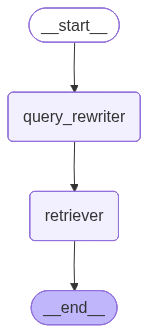

In [9]:
# lets build the graph to test before aggregating the results

graphbuilder = StateGraph(State)

graphbuilder.add_node("query_rewriter", query_rewriter_node)
graphbuilder.add_node("retriever", retrieve_node)

graphbuilder.set_entry_point("query_rewriter")

graphbuilder.add_edge(START, "query_rewriter")
graphbuilder.add_edge("query_rewriter", "retriever")
graphbuilder.add_edge("retriever", END)

graph = graphbuilder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
initial_state = State(user_query="top laptop under 1000$. Show me the kid toys as well. Nice bags for my daughter")

result = graph.invoke(initial_state)

result["retrieved_contextdata"]

#result["expanded_queries"]


['Product ID: B0BKPB2YQ9 - Description: Aceele USB and USB C to Ethernet Adapter, 3.3ft Long Cord,Aluminum 3 Ports USB 3.0 Hub with RJ45 10/100/1000 Gigabit Ethernet Adapter, RJ45+Gigabit LAN Network Adapter with USB C Adapter for Laptop [] - Rating: 4.2',
 'Product ID: B09QS7W8G5 - Description: HP 2022 Newest Pavilion 15.6" FHD 1080P IPS Laptop, 8-Core AMD Ryzen 7-5700U(Up to 4.3GHz, Beat i7-1180G7), 32GB RAM, 1TB NVMe SSD, Numpad, HDMI, WiFi, USB-A&C, Fast Charge, Audio by B&O, Win11 [\'We sell computers with upgraded configurations. If the computer has modifications (listed above), then the manufacturer box is opened for it to be tested and inspected and to install the upgrades to achieve the specifications as advertised. If no modifications are listed, the item is unopened and untested. Defects & blemishes are significantly reduced by our in-depth inspection & testing. Microprocessor: AMD Ryzen 7 5700U (1.8 GHz base clock, up to 4.3 GHz max boost clock, 8 MB L3 cache, 8 cores, 16 t

In [11]:
### Aggregation Node

class AggregationResponse(BaseModel):
    answer: str = Field(description="The answer to the question in a list format.")

@traceable(name="aggregation_node", 
description="This function aggregates the retrieved context data and returns the final answer",
run_type="retriever"
)
def aggregation_node(state: State) -> State:
    """
    This function aggregates the retrieved context data and returns the final answer
    """
    
    prompt_template = """
    You are a specialized Product Expert Assistant. Your goal is to answer customer questions accurately using ONLY the provided product information.

      ### Instructions:
      1. **Source of Truth:** Answer strictly based on the provided "Available Products" section below. Do not use outside knowledge or make assumptions.
      2. **Handling Missing Info:** If the answer cannot be found in the provided products, politely state that you do not have that information. Do not make up features.
      3. **Tone:** Be helpful, professional, and concise.
      4. **Terminology:** Never refer to the text below as "context" or "data." Refer to it naturally as "our current inventory" or "available products."
      5. **output format** - An output of the following format is expected:
          
          1. **Answer:** The answer to the question.
          2. **Context:** The list of the IDs of the chunks that were used to answer the question. Only return the ones that are used in the answer.
          3. **Description:** Short description (1-2 sentences) of the item based on the description provided in the context.

      ### Available Products:
      <inventory_data>
      {{ preprocessed_context }}
      </inventory_data>

      ### Customer Question:
      {{ question }}
      
      ### Expanded Queries by you on the above question:
      {{ expanded_queries }}

      ### Answer:
      """
      
    prompt = Template(prompt_template).render(
                    question=state.user_query, 
                    expanded_queries=state.expanded_queries, 
                    preprocessed_context=state.retrieved_contextdata)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
    model="gpt-4.1-mini",
    messages=[{"role": "system", "content": prompt}],
    response_model=AggregationResponse,
    temperature=0.4
    )
    
    return {
      "answer": response.answer
    }



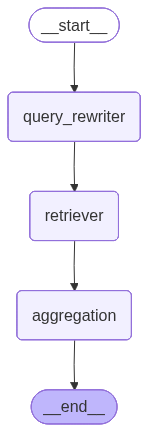

In [12]:
# expand the builder to include the aggregation node

graphbuilder1 = StateGraph(State)

graphbuilder1.add_node("query_rewriter", query_rewriter_node)
graphbuilder1.add_node("retriever", retrieve_node)

graphbuilder1.set_entry_point("query_rewriter")

graphbuilder1.add_edge(START, "query_rewriter")
graphbuilder1.add_edge("query_rewriter", "retriever")
graphbuilder1.add_node("aggregation", aggregation_node)

graphbuilder1.add_edge("retriever", "aggregation")

graphbuilder1.add_edge("aggregation", END)

agg_graph = graphbuilder1.compile()

display(Image(agg_graph.get_graph().draw_mermaid_png()))

In [13]:
from pprint import pprint

initial_state = State(user_query="top laptop under 2000$. Show me the kid toys as well. Nice bags for my daughter")

result = agg_graph.invoke(initial_state)

pprint(result["answer"])


('Top laptops under $2000 from our current inventory include:\n'
 '- HP 2022 Newest Pavilion 15.6" FHD Laptop with AMD Ryzen 7-5700U, 32GB RAM, '
 '1TB SSD, Windows 11 (Product ID: B09QS7W8G5)\n'
 '- 2022 Newest Lenovo IdeaPad 1 Laptop, 14" Anti-Glare Display, Intel '
 'Quad-Core, 4GB RAM, 128GB SSD, Windows 11 + Office 365 (Product ID: '
 'B015TPLFFO)\n'
 '\n'
 'Kid toys available:\n'
 '- QearFun Dinosaur Headphones for Boys Kids, Wired with Microphone (Product '
 'ID: B0B67M9C9P)\n'
 '- QearFun Cat Earbuds for Kids, Wired Earbud with Microphone and Storage '
 'Case (Product ID: B0B67ZFRPC)\n'
 '- AirTag Bracelet Air Tag Wristband for Kids, Silicone Adjustable Band '
 '(Product ID: B0B4N1D73R)\n'
 '\n'
 'Nice bags suitable for your daughter:\n'
 '- Missnine Tote Bag Canvas Laptop Bag 15.6 inch, Large Capacity Handbag for '
 'Women (Product ID: B0BSGDCVND)\n'
 '- EZrelia Pattern 15 inch Waterproof Laptop Shoulder Messenger Bag with '
 'Shockproof Protection (Product ID: B07F9MFVKS)\n'


### Parallel execution of embeddings search

In [60]:
@traceable(name="query_rewriter_node", 
description="This function rewrites the query to be more specific to include multiple statements",
run_type="prompt"
)
def query_rewriter_node(state: State) -> str:
    """
    This function rewrites the query to be more specific to include multiple statements
    """
    
    prompt_template = """
    You are a Shopping Intent Extraction Agent.
    Your task is to analyze a user's complex request and split it into distinct, standalone product search statements.

    ### INSTRUCTIONS
    1. **Identify Entities:** Look for distinct people or needs mentioned (e.g., "for me", "for my kid", "for my wife").
    2. **Segment Requests:** If the user asks for multiple different items, separate them completely. Do not combine them.
    3. **Refine & Standardize:** Convert colloquial phrases into clear, searchable product categories.
        - If the user says "nice toys", convert to "toys for kids" or specific categories if implied.
        - If the user says "I need", infer the target audience based on the context (e.g., "for adults" or "men/women").
    4. **Output List:** Return a raw JSON object containing the list of search statements.
    5. Note: Don't includ below examples in your output.

    ### EXAMPLES

    <Question>
    I need smart watch. My kid needs nice toys. My wife want home appliances.
    </Question>
    <Response>
    {
        "search_queries": [
            "Smart watch for adults",
            "Toys for kids",
            "Home appliances for women"
        ]
    }
    </Response>

    <Question>
    Looking for a gaming laptop for myself and a pink ipad for my daughter.
    </Question>
    <Response>
    {
        "search_queries": [
            "Gaming laptop",
            "Pink iPad for girls"
        ]
    }
    </Response>

    <Question>
    {{ query }}
    </Question>
    <Response>
    """
    
    prompt = Template(prompt_template).render(query=state.user_query)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4o-mini",
        response_model=QueryRewriteResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.4
    )
    return {
        "expanded_queries": response.search_queries
    }

In [66]:
# making retrieve_embedding_data a retriever node for parallel execution
from typing import Dict

@traceable(name="retrieve_embedding_data", 
description="Retrieve embedding data from Qdrant for a given query and collection name",
run_type="retriever"
)
def retrieve_embedding_node(payload):
    qd_client = QdrantClient(url="http://localhost:6333")
    collection_name = "amazon_items-collection-hybrid-02"
    k=5
    
    query = payload["user_query"]
    querry_embeddings = create_embeddings(query)
    
    response = qd_client.query_points(
        collection_name=collection_name,
        prefetch=[Prefetch(
            query=querry_embeddings,
            using="text-embedding-3-small",
            limit=20),
            Prefetch(
                query=Document(text=query, model="qdrant/bm25"),
                using="bm25",
                limit=20)
            ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )
    retrieved_context_ids = []
    retrieved_context = []
    retrieved_scores = []
    retrieved_context_ratings = []
    
    for point in response.points:
        retrieved_context_ids.append(point.payload["parent_asin"])
        retrieved_context.append(point.payload["description"])
        retrieved_scores.append(point.score)
        retrieved_context_ratings.append(point.payload["average_rating"])

    retrieved_contextdata = []
    for item, context, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        product_context = f"Product ID: {item} - Description: {context} - Rating: {rating}"
        retrieved_contextdata.append(product_context)
    
    return {
        "retrieved_contextdata": retrieved_contextdata
    }

In [67]:
from langgraph.types import Send

@traceable(name="execute_parallel_retrieval", 
description="Retrieve embedding data from Qdrant for a given query and collection name",
run_type="retriever"
)
def execute_parallel_retrieval(state: State) -> List[Send]:
    """
    This function retrieves the embedding data from Qdrant for a given query and collection name
    """    
    send_list = []
    for query in state.expanded_queries:
        send_list.append(Send("retrieve_embedding_node", {"user_query": query}))
    
    return send_list

In [63]:
class AggregationResponse(BaseModel):
    answer: str = Field(description="The answer to the question in a list format.")

@traceable(name="aggregation_node", 
description="This function aggregates the retrieved context data and returns the final answer",
run_type="retriever"
)
def aggregation_node(state: State) -> State:
    """
    This function aggregates the retrieved context data and returns the final answer
    """
    
    prompt_template = """
    You are a specialized Product Expert Assistant. Your goal is to answer customer questions accurately using ONLY the provided product information.

      ### Instructions:
      1. **Source of Truth:** Answer strictly based on the provided "Available Products" section below. Do not use outside knowledge or make assumptions.
      2. **Handling Missing Info:** If the answer cannot be found in the provided products, politely state that you do not have that information. Do not make up features.
      3. **Tone:** Be helpful, professional, and concise.
      4. **Terminology:** Never refer to the text below as "context" or "data." Refer to it naturally as "our current inventory" or "available products."
      5. **output format** - An output of the following format is expected:
          
          1. **Answer:** The answer to the question.
          2. **Context:** The list of the IDs of the chunks that were used to answer the question. Only return the ones that are used in the answer.
          3. **Description:** Short description (1-2 sentences) of the item based on the description provided in the context.

      ### Available Products:
      <inventory_data>
      {{ preprocessed_context }}
      </inventory_data>

      ### Customer Question:
      {{ question }}
      
      ### Expanded Queries by you on the above question:
      {{ expanded_queries }}

      ### Answer:
      """
      
    prompt = Template(prompt_template).render(
                    question=state.user_query, 
                    expanded_queries=state.expanded_queries, 
                    preprocessed_context=state.retrieved_contextdata)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
    model="gpt-4.1-mini",
    messages=[{"role": "system", "content": prompt}],
    response_model=AggregationResponse,
    temperature=0.4
    )
    
    return {
      "answer": response.answer
    }

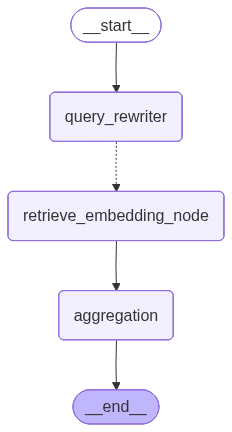

In [68]:
graphbuilder2 = StateGraph(State)

graphbuilder2.add_node("query_rewriter", query_rewriter_node)
graphbuilder2.add_node("retrieve_embedding_node", retrieve_embedding_node)
graphbuilder2.add_node("aggregation", aggregation_node)

graphbuilder2.add_edge(START, "query_rewriter")
graphbuilder2.add_conditional_edges("query_rewriter", execute_parallel_retrieval, {"retrieve_embedding_node": "retrieve_embedding_node"})
graphbuilder2.add_edge("retrieve_embedding_node", "aggregation")
graphbuilder2.add_edge("aggregation", END)

agg_graph_1 = graphbuilder2.compile()

display(Image(agg_graph_1.get_graph().draw_mermaid_png()))

In [69]:
from pprint import pprint

initial_state = State(user_query="top laptop under 2000$. Show me the kid toys as well. Nice bags for my daughter")

result = agg_graph_1.invoke(initial_state)

pprint(result["answer"])

('Laptops under $2000 in our inventory include:\n'
 '- HP 2022 Newest Pavilion 15.6" FHD Laptop with AMD Ryzen 7 5700U, 32GB RAM, '
 '1TB SSD, Windows 11 (Product ID: B09QS7W8G5)\n'
 '- 2022 Newest Lenovo IdeaPad 1 Laptop, 14" Anti-Glare Display, Intel '
 'Quad-Core, 4GB RAM, 128GB SSD, Windows 11 + Office 365 (Product ID: '
 'B015TPLFFO)\n'
 '- jumper Laptop, 16 Inch FHD IPS Display, Intel Celeron Quad Core, 4GB RAM, '
 '128GB Storage, Windows 11 + Office 365 (Product ID: B0CGRSBNY1)\n'
 '\n'
 'Kid toys available:\n'
 '- QearFun Dinosaur Headphones for Boys Kids with Microphone (Product ID: '
 'B0B67M9C9P)\n'
 '- TUNEAKE Kids Headphones, Volume Limited 94dB, Foldable Adjustable, Pink '
 '(Product ID: B0C142QS8X)\n'
 '- AirTag Bracelet Air Tag Wristband for Kids, Adjustable Length, Pink or '
 'Yellow (Product ID: B0B4N1D73R)\n'
 '- All-New 10 and 10 Plus 2021 Tablet Case for Kids, EVA Foam Shockproof '
 'Cover, Multiple Colors (Product ID: B0BL2CZSHT)\n'
 '- QearFun Cat Earbuds for Kid